### Import Libraries

In [1]:
import pandas as pd
import random
import os
import numpy as np
import time
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, plot_confusion_matrix, roc_auc_score

# basics
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

# model
from lightgbm import LGBMClassifier

# resample
from imblearn.over_sampling import SMOTE


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [3]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [4]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in train_x.columns:
        if train_x[col].var() == 0:
            result.append(col)
    return result

In [5]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]


# highly_correlated = [i[1] for i in get_top_correlation(train_x, 2).index]
# train_x = train_x.drop(highly_correlated, axis = 1)
# test_x = test_x.drop(highly_correlated, axis = 1)

In [6]:
ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
      'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
      'Y_11', 'Y_12', 'Y_13', 'Y_14']
ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
             [7, 19], [22, 36.5], [-19.2, 19], 
             [2.4, 4], [-29.2, -24], [-29.2, -24],
             [-30.6, -20], [19.6, 26.6], [-29.2, -24],
             [-29.2, -24], [-29.2, -24]]

### Load Data

In [7]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

cols_with_zero_variance = zero_variance(train_x) # 분산이 0 (통과 여부)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)
test_x = test_x.drop(cols_with_zero_variance, axis = 1)

train_x = train_x.drop(['X_10', 'X_11'], axis = 1) # 결측치가 많음 (결측치 = 0, 공지사항)
test_x = test_x.drop(['X_10', 'X_11'], axis = 1)

test_x = test_x.drop('ID', axis=1)

y_feature_spec_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

In [8]:
df_indicator = pd.DataFrame()
for idx in range(len(ys)):
    y_series = ~train_y[ys[idx]].between(ys_bounds[idx][0], ys_bounds[idx][1])
    df_indicator = pd.concat([df_indicator, y_series.astype(int)], axis = 1)

In [402]:
lst = []
for i in df_indicator.columns:
    lst.append(df_indicator[df_indicator[i] == 1].index)
ans=set()
for i in lst:
    for k in i:
        ans.add(k)
print(len(ans))

3917


In [403]:
lst = []
for i in df_indicator.columns:
    lst.append(df_indicator[df_indicator[i] == 1].index)
ans=set()
for i in lst:
    for k in i:
        ans.add(k)
print(len(ans))

ans = list(ans)
ans.sort()
normal_x = train_x.loc[ans, :]

In [404]:
normal_x = train.drop(normal_x.index)

In [407]:
print(len(train_x) - len(normal_x))

3917


In [452]:
def variable_func(y_val):
    aucs = []

    train = train_x
    target = df_indicator[y_val] # Y_01 에 대한 Classification 

    smote = SMOTE(random_state=1, sampling_strategy='minority', k_neighbors=5)
    model_oof, model_pred = np.zeros(len(train)), np.zeros(len(test_x))
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)

    for fold_ , (train_idx, valid_idx) in enumerate(folds.split(train, target)):

        train_features, valid_features = train.iloc[train_idx], train.iloc[valid_idx]
        train_target, valid_target = target.iloc[train_idx], target.iloc[valid_idx]
 #n_estimators=1000,num_leaves=64,n_jobs=-1,
        train_feature_smote, train_target_smote = smote.fit_resample(train_features, train_target)
        
        model = LGBMClassifier(n_estimators=85, random_state=1, is_unbalance=True, boost_from_average=False)
        model.fit(train_feature_smote, train_target_smote)

        model_oof[valid_idx] = model.predict_proba(valid_features)[:, 1]
        targe = model.predict_proba(train_feature_smote)[:, 1]
        print('Current Fold #', fold_ + 1, 'AUC on validation:' , roc_auc_score(valid_target, model_oof[valid_idx]))

        aucs.append(roc_auc_score(valid_target, model_oof[valid_idx]))
        model_pred += model.predict_proba(test_x)[:, 1] / folds.n_splits

    print('Average AUC: ', np.mean(aucs))
    
    return model.predict(train)


In [453]:
variable_func('Y_01')

Current Fold # 1 AUC on validation: 0.5840102494311777
Current Fold # 2 AUC on validation: 0.5502619062807891
Current Fold # 3 AUC on validation: 0.5927888943231193
Current Fold # 4 AUC on validation: 0.6438818834570211
Current Fold # 5 AUC on validation: 0.6346956712810372
Current Fold # 6 AUC on validation: 0.6049733840843203
Current Fold # 7 AUC on validation: 0.5912641931444839
Current Fold # 8 AUC on validation: 0.5967697333326196
Current Fold # 9 AUC on validation: 0.5768860914415597
Current Fold # 10 AUC on validation: 0.6214739764250835
Average AUC:  0.5997005983201211


array([0, 0, 0, ..., 0, 0, 0])

In [110]:
preds = model.predict(train_x)

In [62]:
preds = pd.DataFrame(preds)

In [64]:
preds.value_counts()

0    38623
1      984
dtype: int64

<AxesSubplot:>

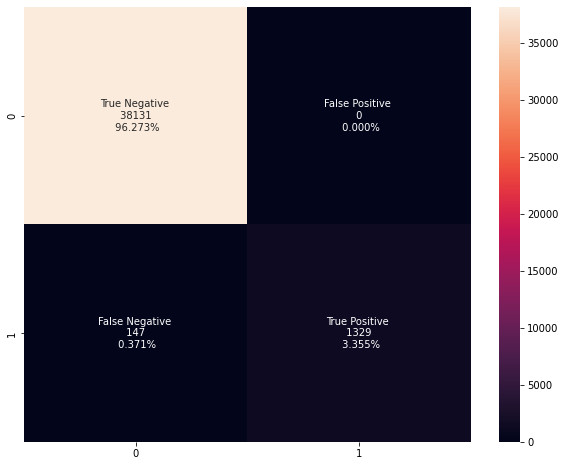

In [42]:
oofs = np.where(model_oof > 0.5, 1, 0)

cm = confusion_matrix(target, oofs) 
groups = ['True Negative','False Positive','False Negative','True Positive']
counts = ["{0:0.0f}".format(val) for val in cm.flatten()]
percent = ["{0:.3%}".format(val) for val in cm.flatten() / np.sum(cm)]
labels = np.asarray([f"{val1} \n {val2} \n {val3}" for val1, val2, val3 in zip(groups, counts, percent)]).reshape(2, 2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = labels, fmt ='')

